In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
from pathlib import Path
import sys
from PIL import Image

sys.path.insert(0, '/workspace/src')
from gaussvae.models.resnet_conv1d_vae import ResNetConv1DVAE

# Configure which images to test
sample_ids = ['img_000001', 'img_000002', 'img_000003', 'img_000004', 'img_000005']

out_dir = Path('/workspace/notebooks/outputs/08_multi')
out_dir.mkdir(parents=True, exist_ok=True)

print(f"Testing {len(sample_ids)} images: {sample_ids}")

2025-11-15 02:56:23.072655: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-15 02:56:24.023261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Testing 5 images: ['img_000001', 'img_000002', 'img_000003', 'img_000004', 'img_000005']


# VAE Multi-Image Reconstruction Demo

Test VAE reconstruction quality across multiple images with side-by-side comparisons.

## Load Model and Normalization Stats

In [ ]:
# Load VAE (ResNet architecture from run_006)
print("Loading VAE model...")
vae = tf.keras.models.load_model(
    '/workspace/experiments/run_006_resnet_512d/checkpoints/vae_epoch_025',
    custom_objects={'ResNetConv1DVAE': ResNetConv1DVAE},
    compile=False
)

# Load normalization stats
stats = np.load('/workspace/data/normalization_stats.npz')
mean = np.concatenate([
    stats['xy_mean'], stats['scale_mean'],
    stats['rot_mean'][None] if stats['rot_mean'].shape == () else stats['rot_mean'],
    stats['feat_mean']
])
std = np.concatenate([
    stats['xy_std'], stats['scale_std'],
    stats['rot_std'][None] if stats['rot_std'].shape == () else stats['rot_std'],
    stats['feat_std']
])

print(f"✓ Model loaded: {vae.count_params()/1e6:.1f}M params")
print(f"✓ Stats loaded: mean shape {mean.shape}, std shape {std.shape}")

Loading VAE model...


2025-11-15 02:56:28.421144: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13744 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


✓ Model loaded: 12.2M params
✓ Stats loaded: mean shape (8,), std shape (8,)


## Batch Reconstruct All Images

In [ ]:
def create_checkpoint(gaussians_array, output_path):
    """Create checkpoint fully compatible with Image-GS rendering."""
    # Load template checkpoint to get metadata structure
    template_path = '/workspace/data/delaunay/checkpoints/train/checkpoints/img_000001.pt'
    template = torch.load(template_path, map_location='cpu')
    
    # Create checkpoint with all required keys
    checkpoint = {
        'state_dict': {
            'xy': torch.from_numpy(gaussians_array[:, 0:2]),
            'scale': torch.from_numpy(gaussians_array[:, 2:4]),
            'rot': torch.from_numpy(gaussians_array[:, 4:5]),
            'feat': torch.from_numpy(gaussians_array[:, 5:8]),
            'vis_feat': torch.zeros((512, 3), dtype=torch.float32)
        },
        # Copy metadata from template (required by Image-GS)
        'optim_state_dict': template['optim_state_dict'],
        'step': template['step'],
        'bytes': template['bytes'],
        'flip': template['flip'],
        'lpips': template['lpips'],
        'msssim': template['msssim'],
        'psnr': template['psnr'],
        'ssim': template['ssim'],
        'time': template['time']
    }
    torch.save(checkpoint, output_path)
    return output_path


print("Processing images...")
mse_scores = {}

for sample_id in sample_ids:
    # Load data
    data = np.load(f'/workspace/data/delaunay/npz/train/{sample_id}.npz')
    gaussians = data['gaussians']
    
    # Reconstruct
    with tf.device('/CPU:0'):
        normalized = (gaussians - mean) / std
        batch = normalized[np.newaxis, ...]
        reconstructed = vae.predict(batch, verbose=0)[0]
        recon_gaussians = reconstructed * std + mean
    
    # Calculate MSE
    mse = np.mean((gaussians - recon_gaussians)**2)
    mse_scores[sample_id] = mse
    
    # Save checkpoints
    input_ckpt = create_checkpoint(gaussians, out_dir / f'{sample_id}.pt')
    vae_ckpt = create_checkpoint(recon_gaussians, out_dir / f'{sample_id}_vae.pt')
    
    print(f"  ✓ {sample_id}: MSE={mse:.6f}")

print(f"\n✓ Created {len(sample_ids) * 2} checkpoints")
print(f"Average MSE: {np.mean(list(mse_scores.values())):.6f}")

Processing images...
  ✓ img_000001: MSE=0.233513
  ✓ img_000002: MSE=0.471788
  ✓ img_000003: MSE=0.256100
  ✓ img_000004: MSE=0.319686
  ✓ img_000005: MSE=0.270675

✓ Created 10 checkpoints
Average MSE: 0.310352


## Render All Checkpoints

**Run these commands in host terminal:**

```bash
cd ~/gaussvae

sudo chown -R $(whoami):$(whoami) /home/roko_cubric555/gaussvae/notebooks/outputs/08_multi

# Render original Gaussians
echo "y" | python scripts/decode_gaussians.py \
  --input notebooks/outputs/08_multi \
  --output notebooks/outputs/08_multi/renders_input \
  --input_images data/delaunay/raw/train

# Render VAE reconstructions
echo "y" | python scripts/decode_gaussians.py \
  --input notebooks/outputs/08_multi \
  --output notebooks/outputs/08_multi/renders_vae \
  --input_images data/delaunay/raw/train
```

**Note:** You'll see warnings about missing `*_vae.png` source images - this is expected and harmless.

## Display Results (Grid View)

In [ ]:
# Check which renders exist
renders_input = out_dir / 'renders_input' / 'images'
renders_vae = out_dir / 'renders_vae' / 'images'

available_samples = []
for sample_id in sample_ids:
    input_path = renders_input / f'{sample_id}.png'
    vae_path = renders_vae / f'{sample_id}_vae.png'
    if input_path.exists() and vae_path.exists():
        available_samples.append(sample_id)

if not available_samples:
    print('No renders found. Run decode_gaussians.py commands from cell above first.')
    print(f'Expected renders in:')
    print(f'  {renders_input}')
    print(f'  {renders_vae}')
else:
    print(f'Found renders for {len(available_samples)} images')
    
    # Create grid visualization
    n_samples = len(available_samples)
    fig, axes = plt.subplots(n_samples, 3, figsize=(18, 6 * n_samples))
    
    # Handle single row case
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, sample_id in enumerate(available_samples):
        # Load images
        original_path = f'/workspace/data/delaunay/raw/train/{sample_id}.png'
        input_render = renders_input / f'{sample_id}.png'
        vae_render = renders_vae / f'{sample_id}_vae.png'
        
        img_original = Image.open(original_path)
        img_input = Image.open(input_render)
        img_vae = Image.open(vae_render)
        
        # Plot row
        axes[i, 0].imshow(img_original)
        axes[i, 0].set_title(f'{sample_id}\nOriginal PNG', fontsize=14, fontweight='bold')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(img_input)
        axes[i, 1].set_title(f'Image-GS\n(512 Gaussians)', fontsize=14, fontweight='bold')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(img_vae)
        mse = mse_scores.get(sample_id, 0)
        axes[i, 2].set_title(f'VAE Reconstruction\n(MSE={mse:.6f})', fontsize=14, fontweight='bold')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(out_dir / 'comparison_grid.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'\n✓ Saved: {out_dir}/comparison_grid.png')
    print(f'\nMSE Statistics:')
    print(f'  Mean: {np.mean(list(mse_scores.values())):.6f}')
    print(f'  Std:  {np.std(list(mse_scores.values())):.6f}')
    print(f'  Min:  {min(mse_scores.values()):.6f} ({min(mse_scores, key=mse_scores.get)})')
    print(f'  Max:  {max(mse_scores.values()):.6f} ({max(mse_scores, key=mse_scores.get)})')

Found renders for 5 images



✓ Saved: /workspace/notebooks/outputs/08_multi/comparison_grid.png

MSE Statistics:
  Mean: 0.310352
  Std:  0.085522
  Min:  0.233513 (img_000001)
  Max:  0.471788 (img_000002)


## Individual Comparisons (Optional)

View each image pair separately for detailed inspection.

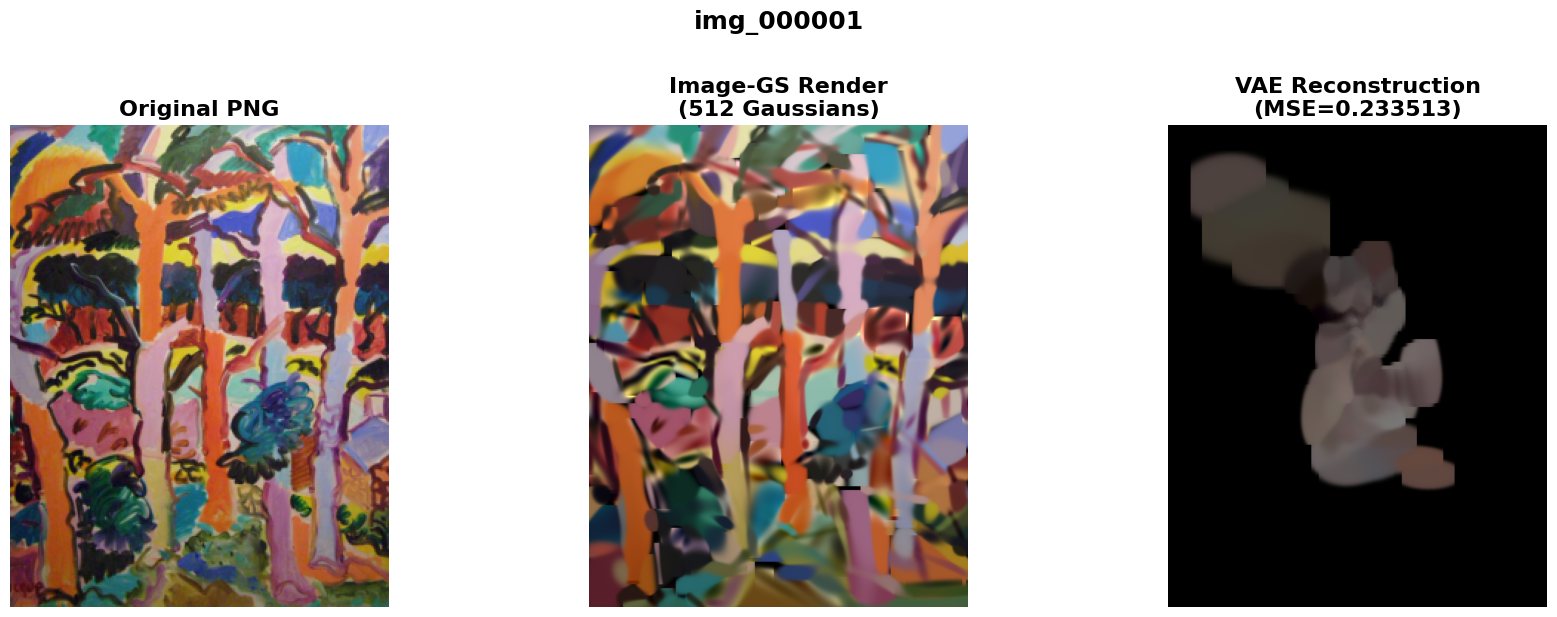

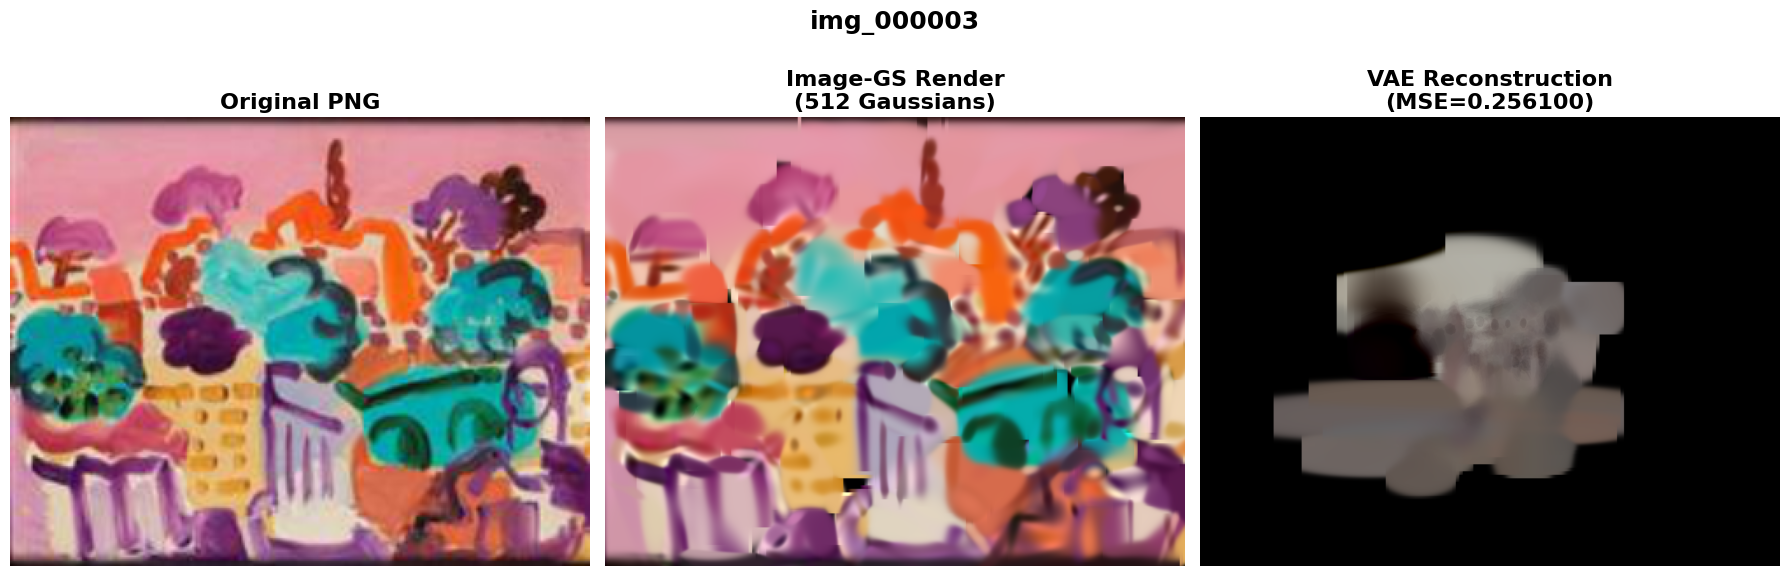

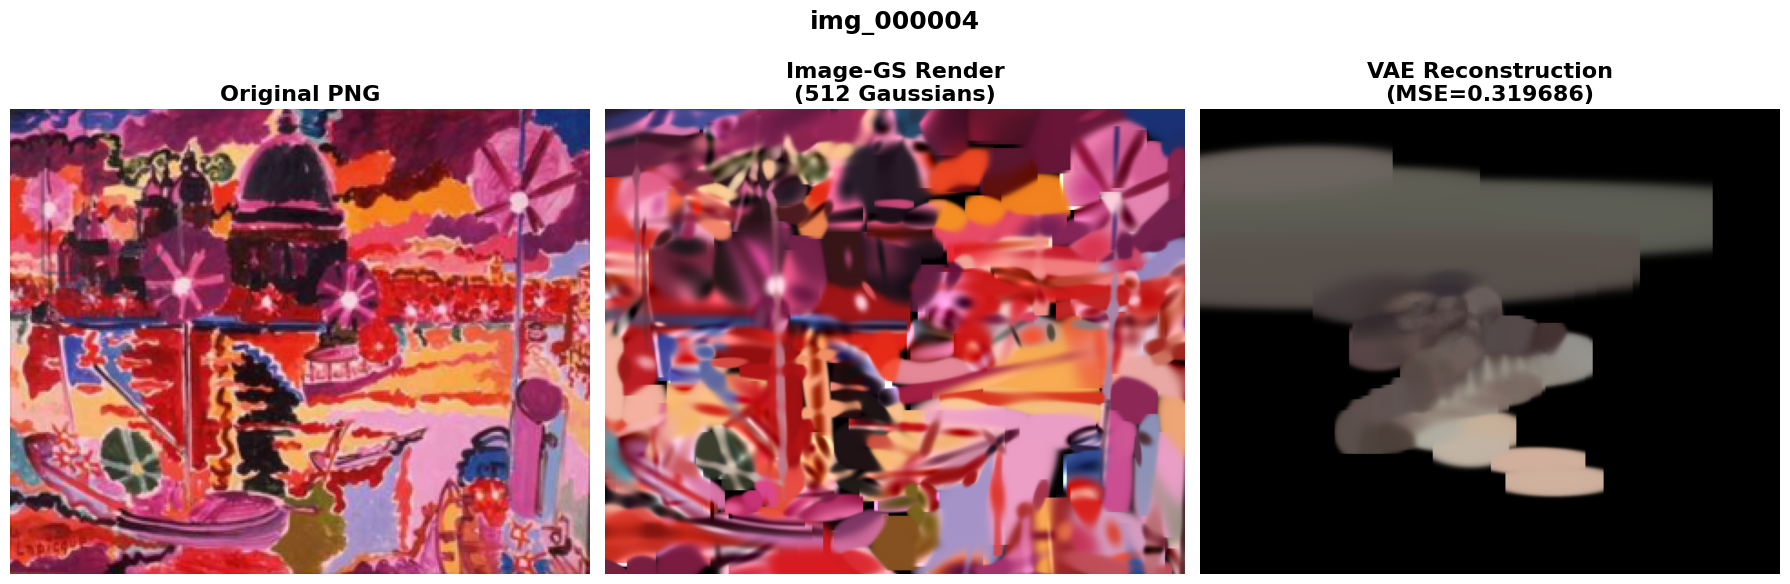

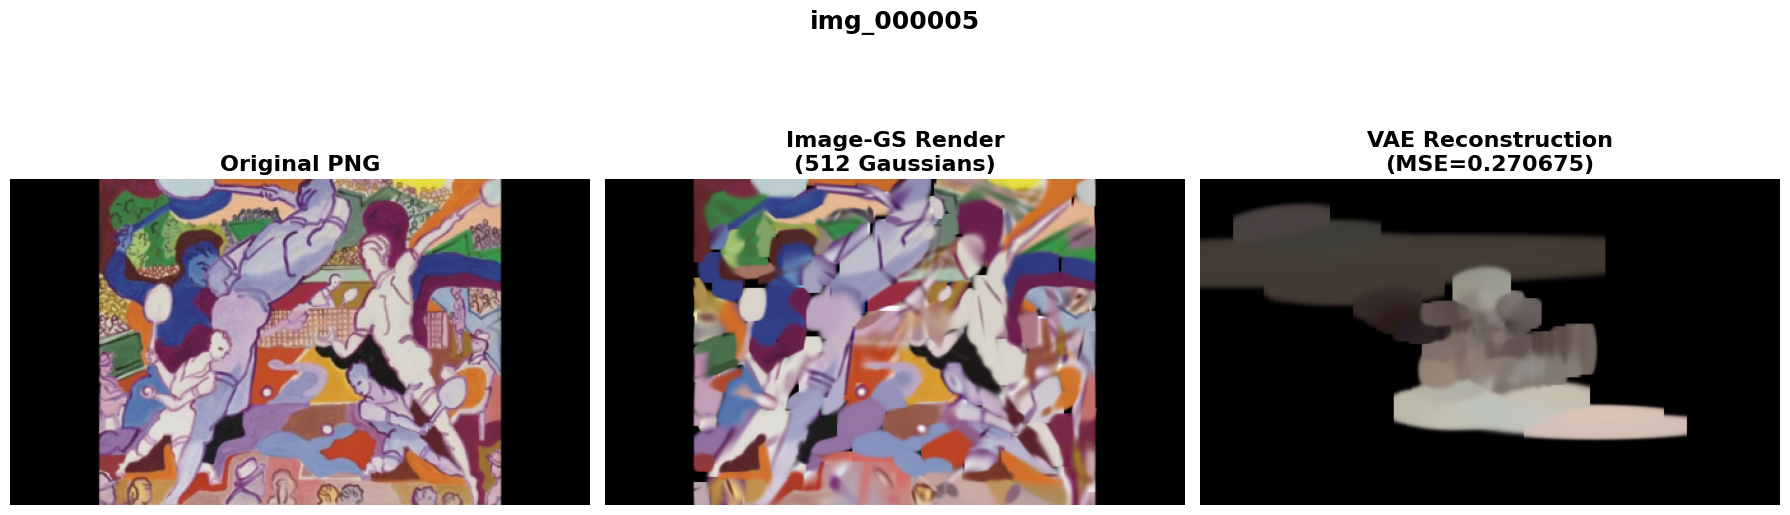

In [ ]:
if available_samples:
    for sample_id in available_samples:
        original_path = f'/workspace/data/delaunay/raw/train/{sample_id}.png'
        input_render = renders_input / f'{sample_id}.png'
        vae_render = renders_vae / f'{sample_id}_vae.png'
        
        img_original = Image.open(original_path)
        img_input = Image.open(input_render)
        img_vae = Image.open(vae_render)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        axes[0].imshow(img_original)
        axes[0].set_title('Original PNG', fontsize=16, fontweight='bold')
        axes[0].axis('off')
        
        axes[1].imshow(img_input)
        axes[1].set_title('Image-GS Render\n(512 Gaussians)', fontsize=16, fontweight='bold')
        axes[1].axis('off')
        
        axes[2].imshow(img_vae)
        mse = mse_scores.get(sample_id, 0)
        axes[2].set_title(f'VAE Reconstruction\n(MSE={mse:.6f})', fontsize=16, fontweight='bold')
        axes[2].axis('off')
        
        plt.suptitle(sample_id, fontsize=18, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        print()
else:
    print('No renders available for individual comparisons')